In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import time
import os
import zipfile
from scipy.signal import medfilt
# from tqdm import tqdm
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve,classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from collections import Counter

import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc, precision_recall_curve, average_precision_score, precision_recall_curve, average_precision_score, precision_score, recall_score,f1_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import plot_model
import visualkeras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns 


Running the code on Tnsorflow-gpu, GPU Device : Nvidia GRTX 3060 6G

In [2]:
def check_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"GPUs found: {len(gpus)}")
        for gpu in gpus:
            print(f"GPU: {gpu}")
    else:
        print("No GPUs found.")


check_gpu()

GPUs found: 1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Part 1: Preproccesing the Data 
So far we have a folder of dataset(for each participaint) which the amplitude of the each siganl from 4 different detectors are calculated and unwanted labels are removed.  
Now we convert this datasets with combining, normalizing etc.. in order to prepare them for training. 


In [3]:
# loading the dataset, convertion to the big dataset 

def combine_csv_files(folder_path):
    
    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    dataframes = []
    
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        dataframes.append(df)
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    return combined_df

folder_path = 'D:/PhysicsofData/HDA/HDA_PROJECT2/Norm_dataset'

#here we combined the datasets and now we have a bigger dataset with 4 different signals having activity as lables (almost 2M rows)
#we already remove the gravitation effect by taking the apmlitude of the signals for each detector

In [3]:
df= pd.read_csv('df.csv')
columns = df.columns
print('Columns',columns)


FileNotFoundError: [Errno 2] No such file or directory: 'df.csv'

In [5]:
# Baseline wander removal function
def baseline_wander_removal(data):
    # Sampling frequency
    fs = 100  
    # Baseline estimation
    win_size = int(np.round(0.2 * fs)) + 1
    baseline = medfilt(data, win_size)

    win_size = int(np.round(0.6 * fs)) + 1
    baseline = medfilt(baseline, win_size)

    # Removing baseline
    filt_data = data - baseline
    return filt_data




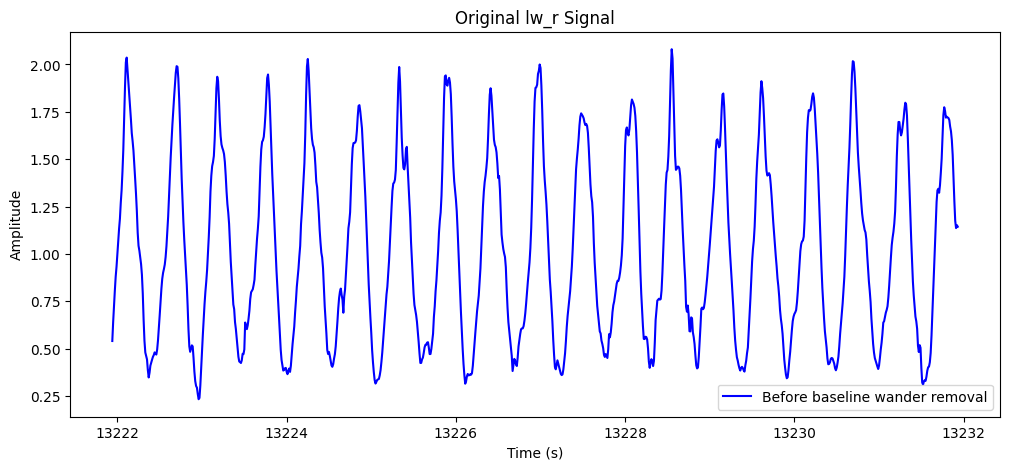

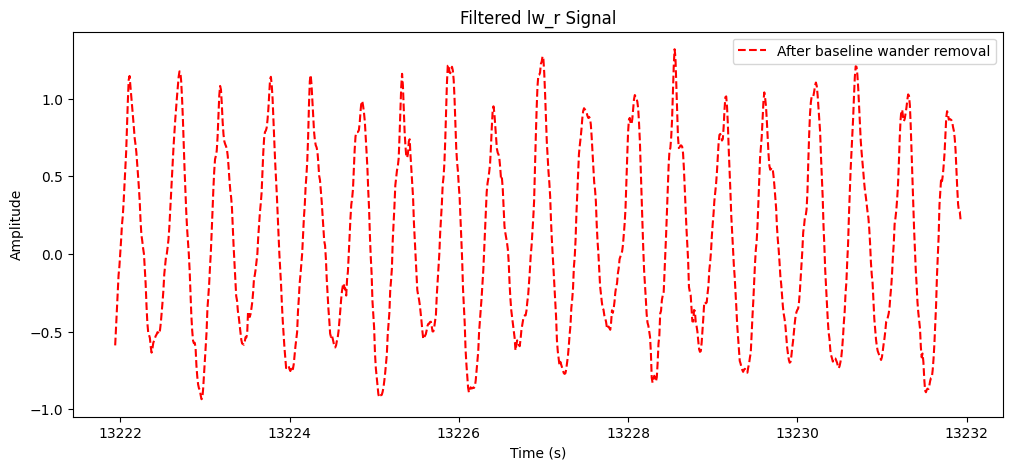

In [6]:
# Apply the baseline wander removal to the 'lw_r' signal
df['lw_r_filtered'] = baseline_wander_removal(df['lw_r'].values)

# Function to plot a random window before and after filtering
def plot_random_window(data, column, filtered_column, window_duration=10):
    # Convert window duration from seconds to number of samples
    num_samples = int(window_duration / 0.01)
    
    # Select a random starting point
    start_idx = np.random.randint(0, len(data) - num_samples)
    window = data.iloc[start_idx:start_idx + num_samples]
    
    # Plot the original signal
    plt.figure(figsize=(12, 5))
    plt.plot(window['time_s'], window[column], label='Before baseline wander removal', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Original {column} Signal')
    plt.legend()
    plt.show()
    
    # Plot the filtered signal
    plt.figure(figsize=(12, 5))
    plt.plot(window['time_s'], window[filtered_column], label='After baseline wander removal', color='red', linestyle='dashed')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Filtered {column} Signal')
    plt.legend()
    plt.show()

# Plot a random window of the 'lw_r' signal before and after applying the baseline wander removal
plot_random_window(df, 'lw_r', 'lw_r_filtered')

Applying the baseline_wander_removal to the whole dataset (to the 4 different signals : 'lw_r', 'lh_r', 'la_r', 'ra_r' )

In [7]:
df = pd.read_csv('df.csv')

signal_columns = ['lw_r', 'lh_r', 'la_r', 'ra_r']
filtered_signals = {col: baseline_wander_removal(df[col].values) for col in signal_columns}
df_removal = pd.DataFrame(filtered_signals)
df_removal['activity'] = df['activity']
df_removal['time_s'] = df['time_s']

df_removal = df_removal[['time_s', 'activity'] + signal_columns]




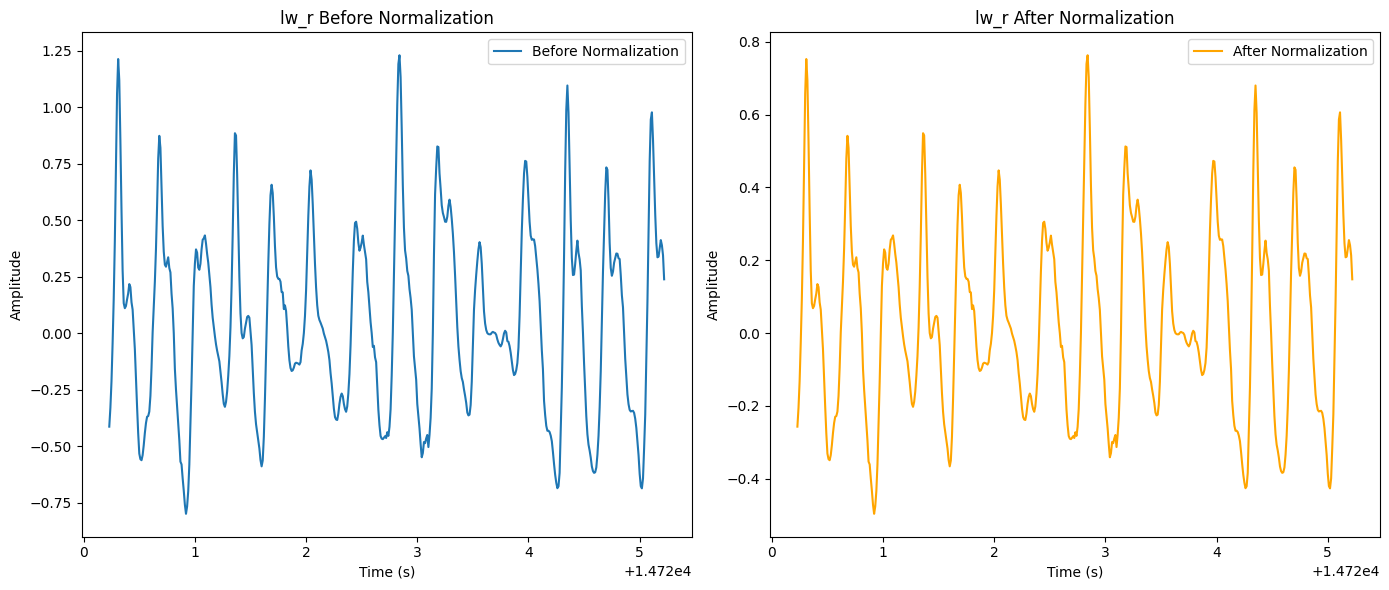

In [8]:
def normalize_data(data):
    # Amplitude estimate
    norm_factor = np.percentile(data, 99) - np.percentile(data, 5)
    return (data / norm_factor)

normalized_signals = {col: normalize_data(df_removal[col].values) for col in signal_columns}

# Create a new dataframe with the normalized signals
df_normalized = pd.DataFrame(normalized_signals)


df_normalized['activity'] = df_removal['activity']
df_normalized['time_s'] = df_removal['time_s']

# Reorder columns if needed
df_normalized = df_normalized[['time_s', 'activity'] + signal_columns]


def plot_signal_comparison(df_before, df_after, column_name, window_size=100):

    # Ensure the window size does not exceed the dataframe length
    max_start = len(df_before) - window_size
    if max_start <= 0:
        raise ValueError("Window size is too large for the dataframe length.")
    
    # Select a random starting point for the window
    start_idx = np.random.randint(0, max_start)
    end_idx = start_idx + window_size
    
    # Extract the window of data
    time_window = df_before['time_s'].iloc[start_idx:end_idx]
    signal_before = df_before[column_name].iloc[start_idx:end_idx]
    signal_after = df_after[column_name].iloc[start_idx:end_idx]

    plt.figure(figsize=(14, 6))

    # Plot original signal
    plt.subplot(1, 2, 1)
    plt.plot(time_window, signal_before, label='Before Normalization')
    plt.title(f'{column_name} Before Normalization')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plot normalized signal
    plt.subplot(1, 2, 2)
    plt.plot(time_window, signal_after, label='After Normalization', color='orange')
    plt.title(f'{column_name} After Normalization')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_signal_comparison(df_removal, df_normalized, 'lw_r', window_size=500)


In [9]:
def label_count(label): #counts the lables in the dataset 
    label_counts = Counter(label)
    print("Label counts using Counter:")
    for label, count in label_counts.items():
        print(f'Label: {label}, Count: {count}')



Label counts using Counter:
Label: 1, Count: 1546298
Label: 2, Count: 264317
Label: 3, Count: 274880


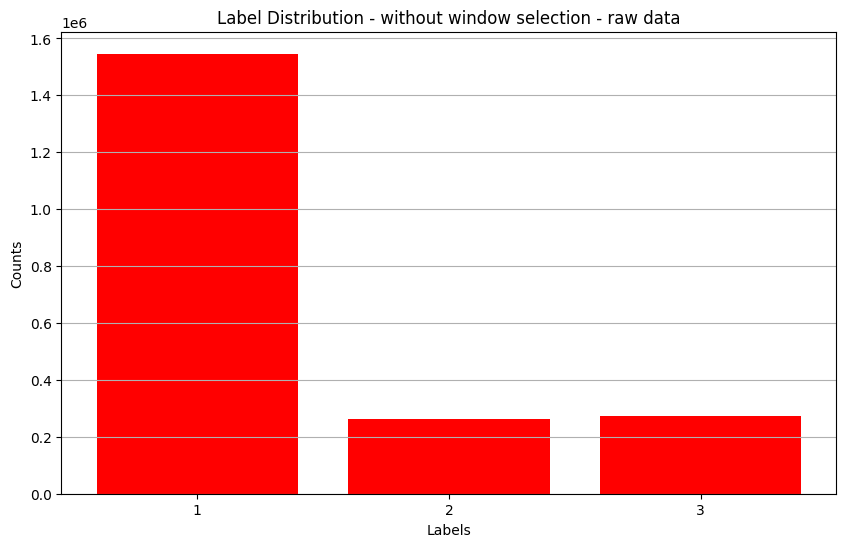

In [10]:

activity = df_normalized['activity']
label_count(activity)
def plot_label_counts(labels):

    # Count the occurrences of each label
    label_counts = Counter(labels)
    
    # Extract labels and their counts
    labels, counts = zip(*label_counts.items())

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='red')
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title('Label Distribution - without window selection - raw data')
    plt.xticks(labels)
    plt.grid(axis='y')
    plt.show()


plot_label_counts(activity)

# 00 : General Functions 

In [30]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_prc(y_true, y_pred_probs, class_names):
    y_true_binarized = label_binarize(y_true, classes=np.arange(len(class_names)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 5))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        average_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred_probs[:, i])

    plt.figure(figsize=(8, 5))
    for i in range(len(class_names)):
        plt.plot(recall[i], precision[i], label=f'{class_names[i]} (average precision = {average_precision[i]:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

class_names = ['1-walking', '2-desc stairs', '3-asce stairs']


def create_windows(df, window, step, signal): # Creates windoes from the dataset 

    windows = []
    labels = []

    start = 0
    end = len(df)

    while start + window <= end:
        window_df = df.iloc[start:start + window]
        
        # Check if all activity values in the window are the same
        if window_df['activity'].nunique() == 1:
            window_signal = window_df[signal].values
            windows.append(window_signal)
            labels.append(window_df['activity'].iloc[0])
        
        start += step
        
    return np.array(windows), np.array(labels)


def prep(df,window_size=256,step=256, signal='lw_r' ,test_size=0.3):

    
    windows, labels = create_windows(df, window=window_size, step=step, signal=signal)
    label_count(labels)
    # plot_label_counts(labels)
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_encoded), y=labels_encoded)
    class_weights_dict = dict(enumerate(class_weights))

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        windows, labels_encoded, test_size=test_size, stratify=labels_encoded, random_state=123
    )

    train_class_distribution = {label: count for label, count in zip(*np.unique(y_train, return_counts=True))}
    test_class_distribution = {label: count for label, count in zip(*np.unique(y_test, return_counts=True))}

    print("Train class distribution:", train_class_distribution)
    print("Test class distribution:", test_class_distribution)
    # Reshape data for CNN input

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Print shapes for verification
    print(f'X_train shape: {X_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'y_test shape: {y_test.shape}')



    return X_train, X_test, y_train, y_test,class_weights_dict


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.2,patience=5,verbose=1, mode='auto',min_lr=1e-5)

# Part 1: First model, CNN 
Here we build two different models applying them on the differend window selection (256,512,1024)

In [12]:

def build_cnn_model(input_size, num_classes=3):
    input_shape = (input_size,1)
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=512, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  ])

    return model




In [29]:
def results(df,window_size,step_size,signal2,epoch = 30,batch_size =64):
    
    X_train, X_test, y_train, y_test,class_weights_dict =prep(df=df,window_size=window_size,step=step_size,signal=signal2)
    
    model = build_cnn_model(input_size=window_size,num_classes=3)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.2,patience=5,verbose=1, mode='auto',min_lr=1e-5)


    history = model.fit(X_train, y_train, validation_split=0.2, epochs=epoch, batch_size=batch_size, 
                         class_weight=class_weights_dict, callbacks=[reduce_lr])
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    plot_training_history(history)
    plot_roc_prc(y_test, y_pred_probs, class_names)
    final_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    final_precision = precision_score(y_test, y_pred, average='weighted')
    final_recall = recall_score(y_test, y_pred, average='weighted')
    final_f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'Final Accuracy: {final_accuracy}')
    print(f'Final Precision: {final_precision}')
    print(f'Final Recall: {final_recall}')
    print(f'Final F1 Score: {final_f1}')
    plot_confusion_matrix(y_test, y_pred, class_names)
    
    return history

###  Window selection 
In order to analyze the signal and import it in the model, we select a window of the dataset and adding it to an array with size of the window keeping the label for that window. 
The condition that the label('activity'), should be the same for the window. 
With the step value, next starting index will be selected. 

## Part 1-2 : 256 samples per window (2.5 s activity),Step size : 256

 since there are 4 different signals, the model is tested on the all signals seprately for a fixed window size 

#### 'lw_r' signal 

Label counts using Counter:
Label: 1, Count: 5923
Label: 2, Count: 839
Label: 3, Count: 876
Train class distribution: {0: 4146, 1: 587, 2: 613}
Test class distribution: {0: 1777, 1: 252, 2: 263}
X_train shape: (5346, 256, 1)
X_test shape: (2292, 256, 1)
y_train shape: (5346,)
y_test shape: (2292,)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_100 (Conv1D)         (None, 254, 64)           256       
                                                                 
 batch_normalization_100 (Ba  (None, 254, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_100 (MaxPooli  (None, 127, 64)          0         
 ng1D)                                                           
                                                                 
 dropout_150 (Drop

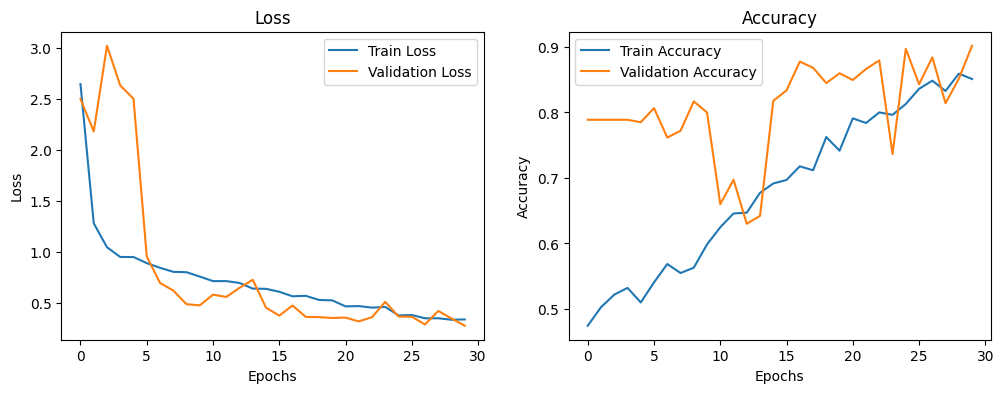

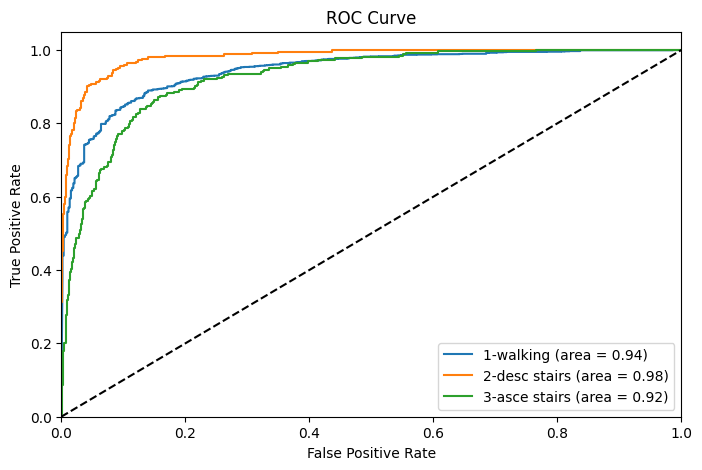

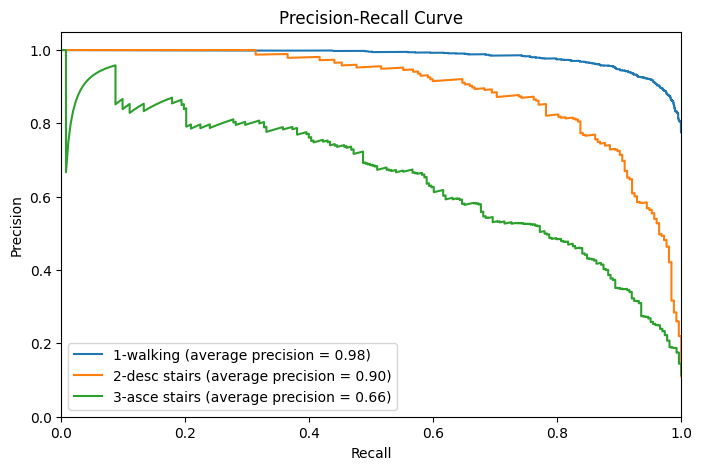

Final Accuracy: 0.8743455410003662
Final Precision: 0.8782563520439651
Final Recall: 0.8743455497382199
Final F1 Score: 0.8752658680597207


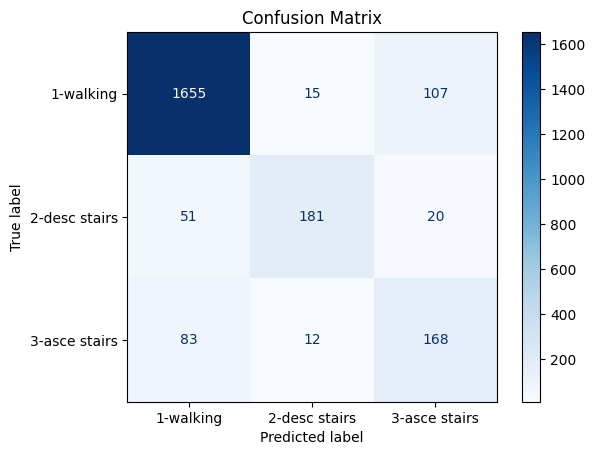

In [37]:
hist = results(df_normalized,window_size=256,step_size=256,signal2='lw_r',epoch = 30 ,batch_size =32)

Based on the previous results, selecting a window with the label, there are much more from label 1 in the dataset,so we are facing an imbalanced data. Using class weights helps to resolve part of this problem

### 'lh_r' Signal 256 

Label counts using Counter:
Label: 1, Count: 5923
Label: 2, Count: 839
Label: 3, Count: 876
Train class distribution: {0: 4146, 1: 587, 2: 613}
Test class distribution: {0: 1777, 1: 252, 2: 263}
X_train shape: (5346, 256, 1)
X_test shape: (2292, 256, 1)
y_train shape: (5346,)
y_test shape: (2292,)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_104 (Conv1D)         (None, 254, 64)           256       
                                                                 
 batch_normalization_104 (Ba  (None, 254, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_104 (MaxPooli  (None, 127, 64)          0         
 ng1D)                                                           
                                                                 
 dropout_156 (Drop

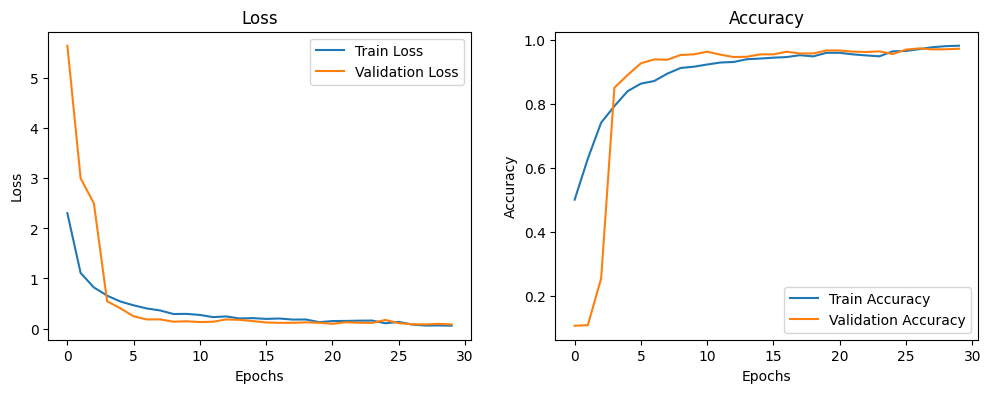

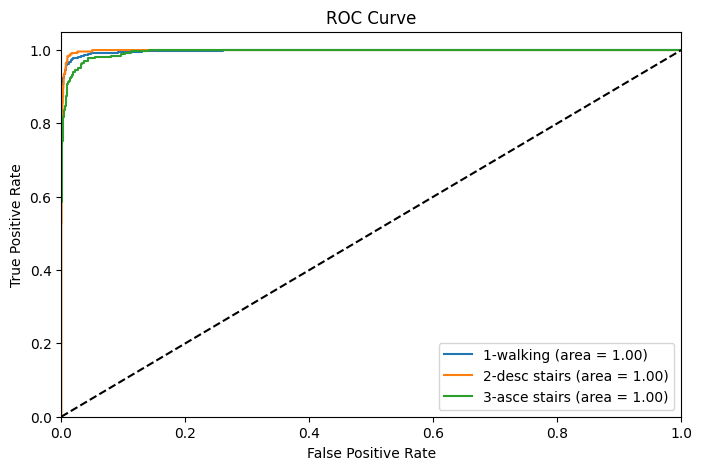

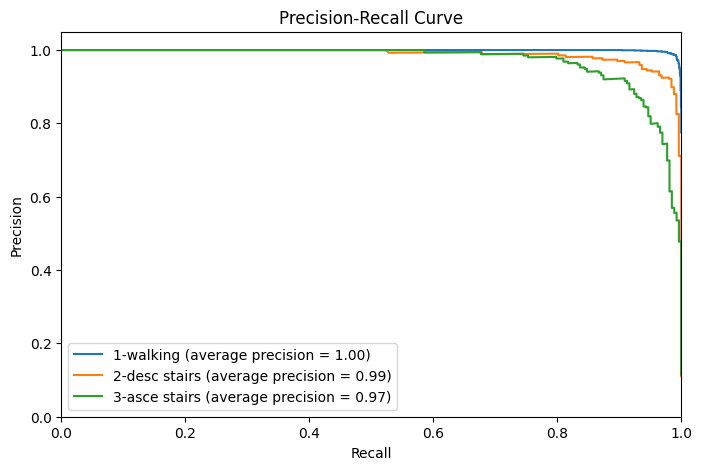

Final Accuracy: 0.9760034680366516
Final Precision: 0.9758233492690311
Final Recall: 0.9760034904013961
Final F1 Score: 0.9758860854455849


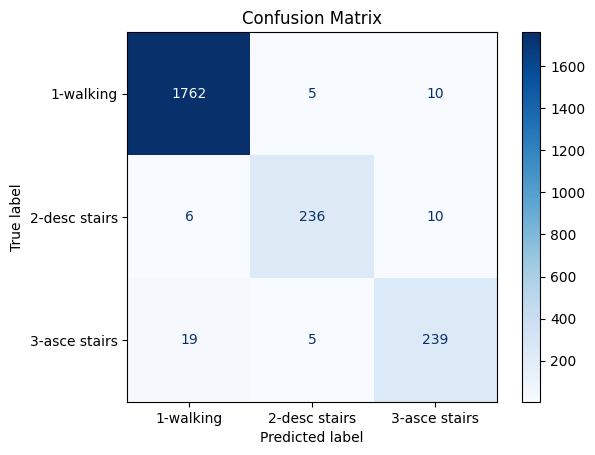

In [38]:
lh_r_256 = results(df_normalized,window_size=256,step_size=256,signal2='lh_r',epoch = 30 ,batch_size =32)

### la_r Signal 


Label counts using Counter:
Label: 1, Count: 5923
Label: 2, Count: 839
Label: 3, Count: 876
Train class distribution: {0: 4146, 1: 587, 2: 613}
Test class distribution: {0: 1777, 1: 252, 2: 263}
X_train shape: (5346, 256, 1)
X_test shape: (2292, 256, 1)
y_train shape: (5346,)
y_test shape: (2292,)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_108 (Conv1D)         (None, 254, 64)           256       
                                                                 
 batch_normalization_108 (Ba  (None, 254, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_108 (MaxPooli  (None, 127, 64)          0         
 ng1D)                                                           
                                                                 
 dropout_162 (Drop

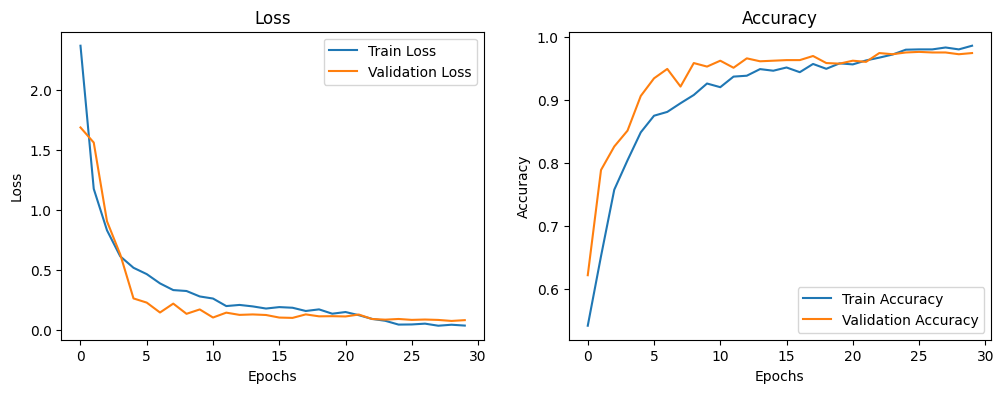

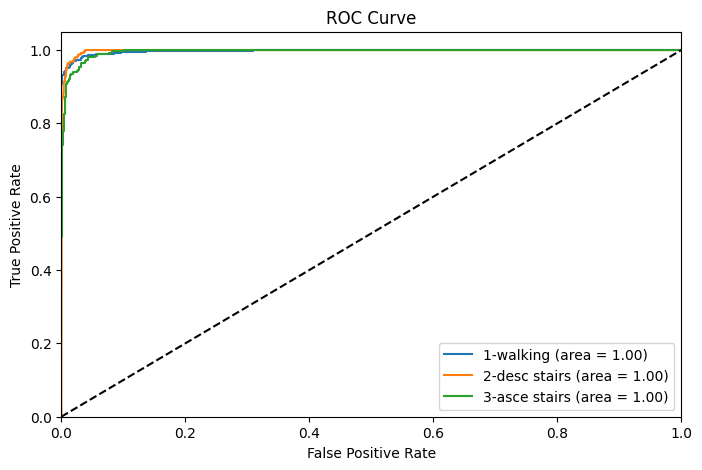

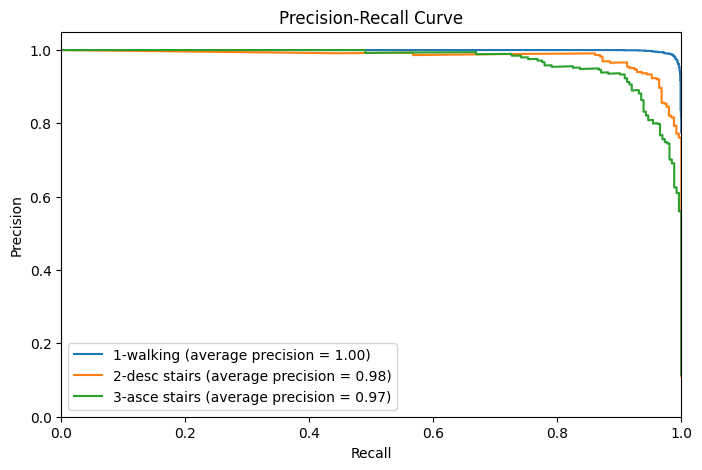

Final Accuracy: 0.9729493856430054
Final Precision: 0.9730217007209576
Final Recall: 0.9729493891797557
Final F1 Score: 0.9729594450247934


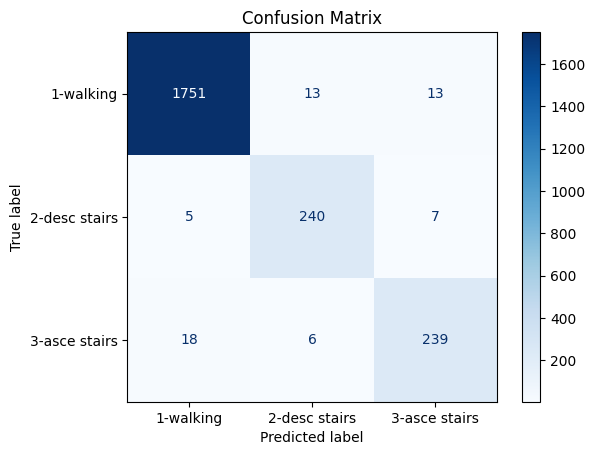

In [39]:
la_r256=results(df_normalized,window_size=256,step_size=256,signal2='lh_r',epoch = 30 ,batch_size =32)

### ra_r 256 100

Label counts using Counter:
Label: 1, Count: 5923
Label: 2, Count: 839
Label: 3, Count: 876
Train class distribution: {0: 4146, 1: 587, 2: 613}
Test class distribution: {0: 1777, 1: 252, 2: 263}
X_train shape: (5346, 256, 1)
X_test shape: (2292, 256, 1)
y_train shape: (5346,)
y_test shape: (2292,)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_112 (Conv1D)         (None, 254, 64)           256       
                                                                 
 batch_normalization_112 (Ba  (None, 254, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_112 (MaxPooli  (None, 127, 64)          0         
 ng1D)                                                           
                                                                 
 dropout_168 (Drop

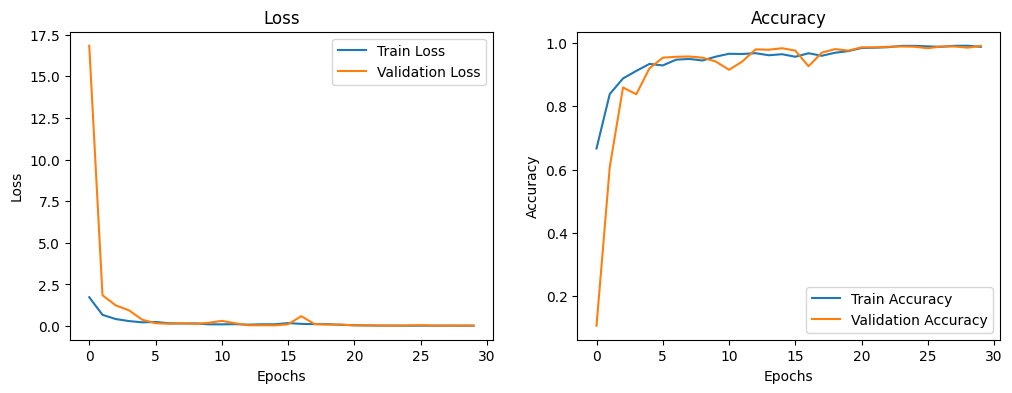

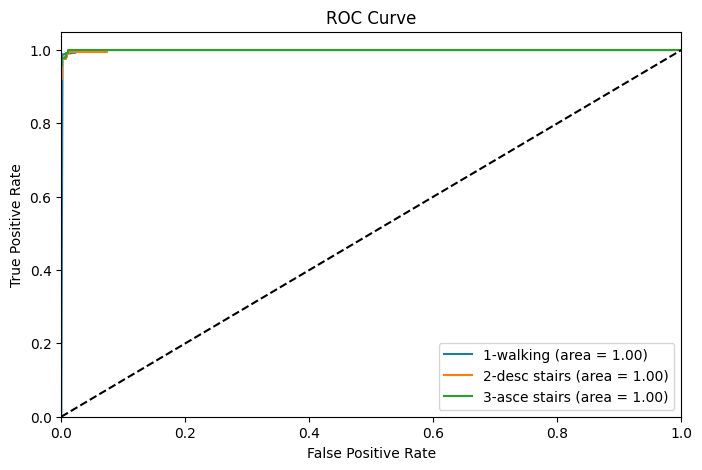

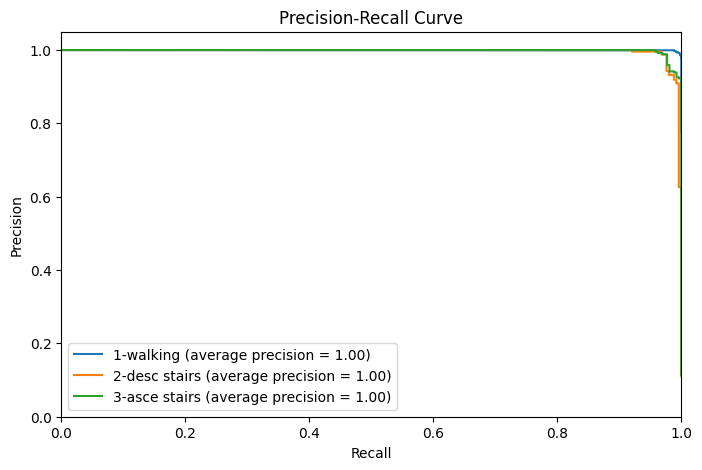

Final Accuracy: 0.9904013872146606
Final Precision: 0.9903885982786179
Final Recall: 0.9904013961605584
Final F1 Score: 0.9903677883366863


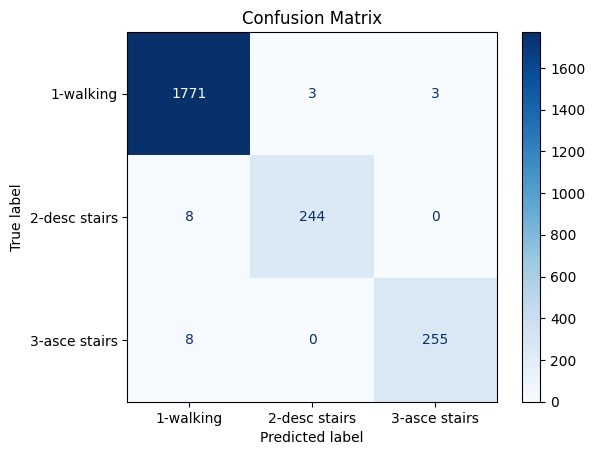

In [40]:
ra_r256=results(df_normalized,window_size=256,step_size=256,signal2='ra_r',epoch = 30 ,batch_size =32)

# Part 2 : 512 samples

signal selected: lw_r
Label counts using Counter:
Label: 1, Count: 2894
Label: 2, Count: 323
Label: 3, Count: 348
Train class distribution: {0: 2025, 1: 226, 2: 244}
Test class distribution: {0: 869, 1: 97, 2: 104}
X_train shape: (2495, 512, 1)
X_test shape: (1070, 512, 1)
y_train shape: (2495,)
y_test shape: (1070,)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_116 (Conv1D)         (None, 510, 64)           256       
                                                                 
 batch_normalization_116 (Ba  (None, 510, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_116 (MaxPooli  (None, 255, 64)          0         
 ng1D)                                                           
                                                                

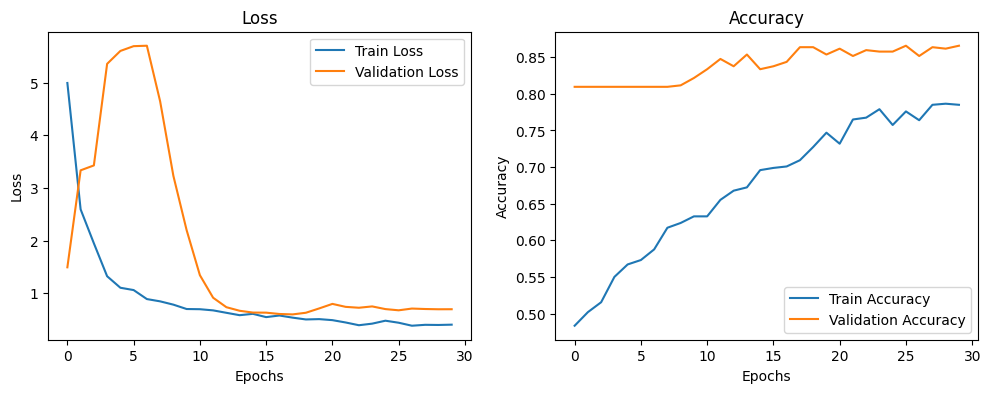

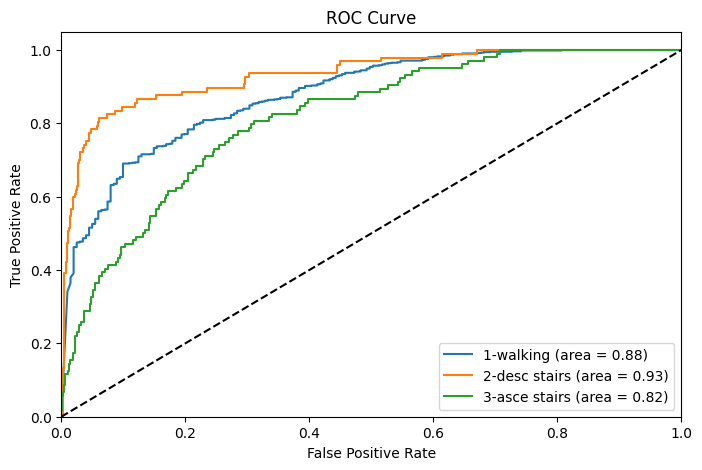

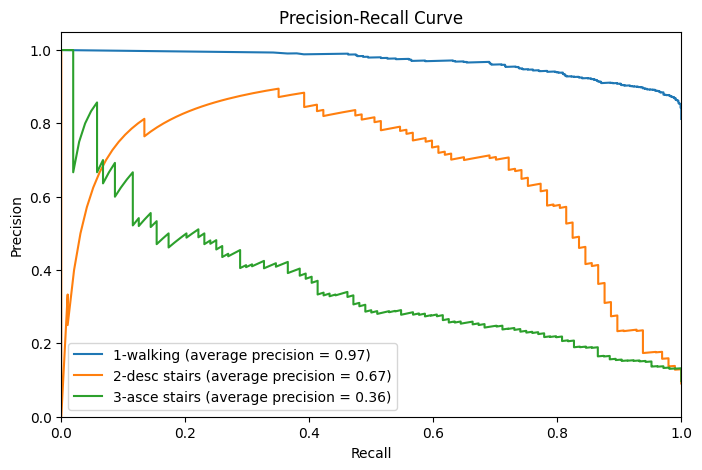

Final Accuracy: 0.8560747504234314
Final Precision: 0.8300737354142805
Final Recall: 0.8560747663551402
Final F1 Score: 0.8315423888972407


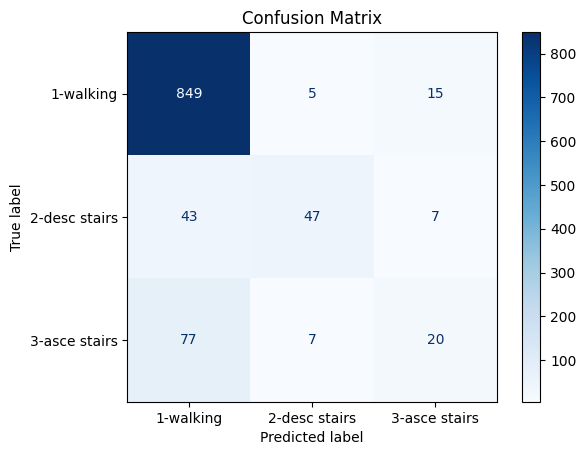

signal selected: lh_r
Label counts using Counter:
Label: 1, Count: 2894
Label: 2, Count: 323
Label: 3, Count: 348
Train class distribution: {0: 2025, 1: 226, 2: 244}
Test class distribution: {0: 869, 1: 97, 2: 104}
X_train shape: (2495, 512, 1)
X_test shape: (1070, 512, 1)
y_train shape: (2495,)
y_test shape: (1070,)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_120 (Conv1D)         (None, 510, 64)           256       
                                                                 
 batch_normalization_120 (Ba  (None, 510, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_120 (MaxPooli  (None, 255, 64)          0         
 ng1D)                                                           
                                                                

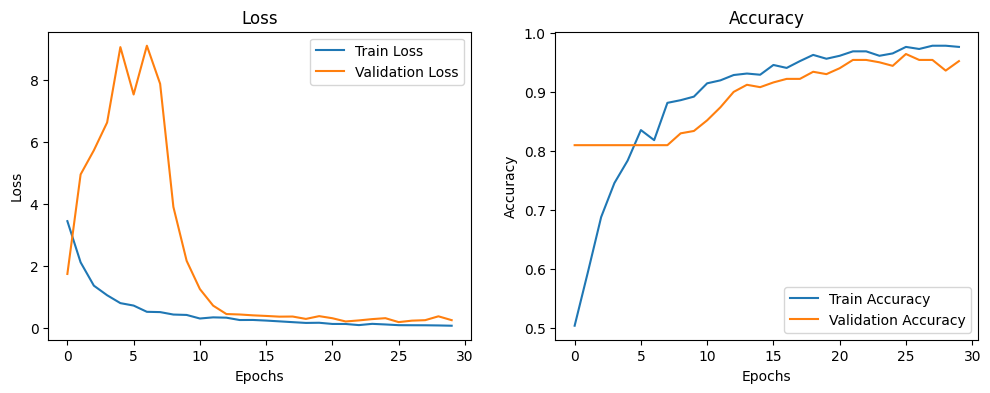

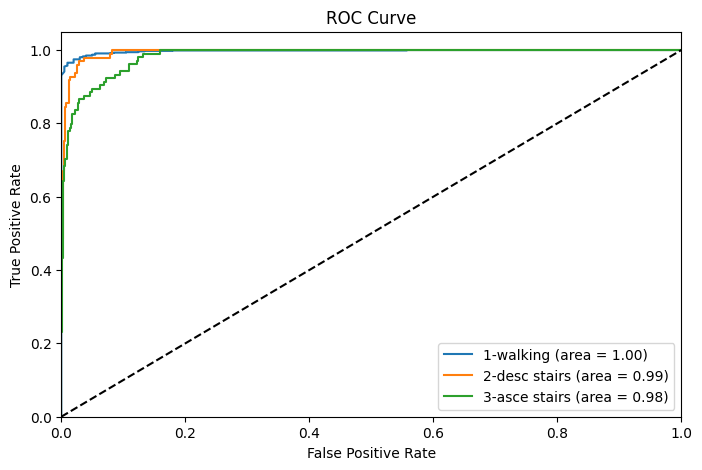

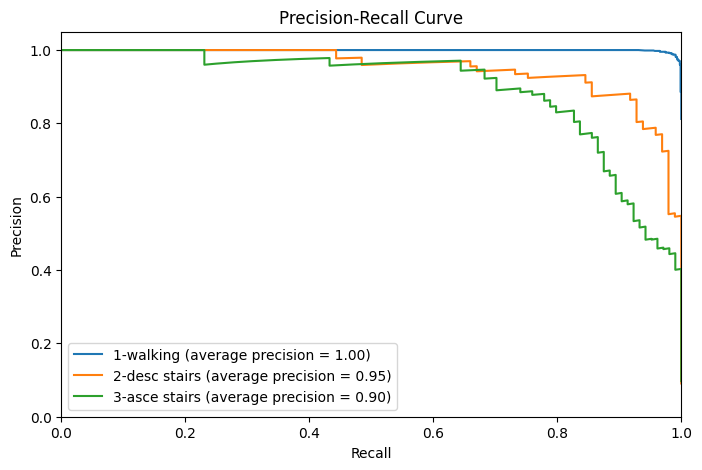

Final Accuracy: 0.9579439163208008
Final Precision: 0.9563441684578735
Final Recall: 0.9579439252336449
Final F1 Score: 0.9561176202345656


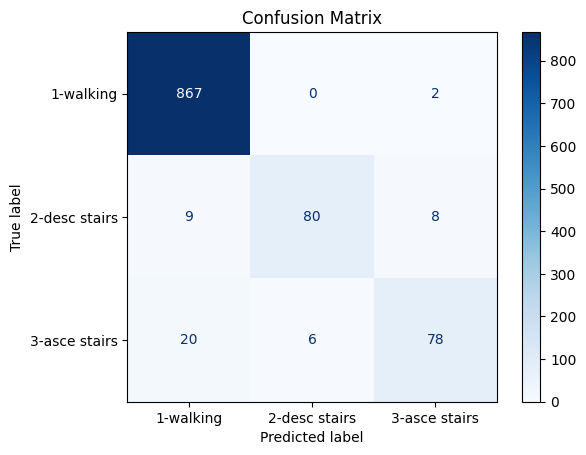

signal selected: la_r
Label counts using Counter:
Label: 1, Count: 2894
Label: 2, Count: 323
Label: 3, Count: 348
Train class distribution: {0: 2025, 1: 226, 2: 244}
Test class distribution: {0: 869, 1: 97, 2: 104}
X_train shape: (2495, 512, 1)
X_test shape: (1070, 512, 1)
y_train shape: (2495,)
y_test shape: (1070,)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_124 (Conv1D)         (None, 510, 64)           256       
                                                                 
 batch_normalization_124 (Ba  (None, 510, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_124 (MaxPooli  (None, 255, 64)          0         
 ng1D)                                                           
                                                                

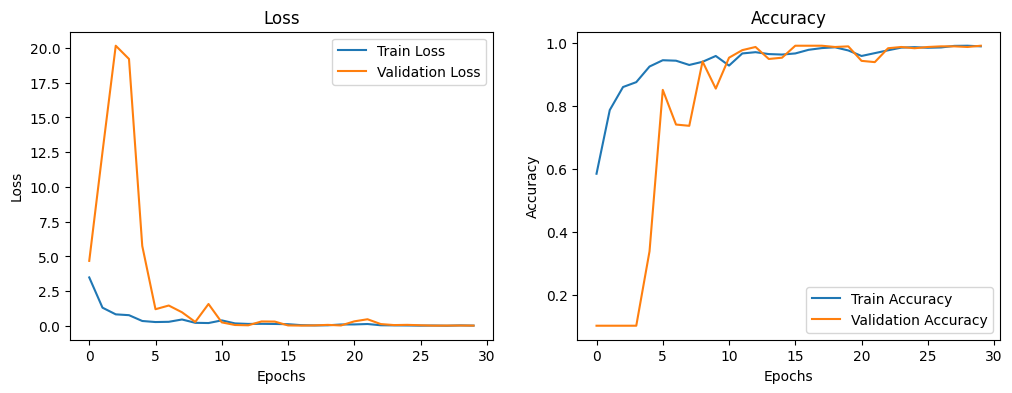

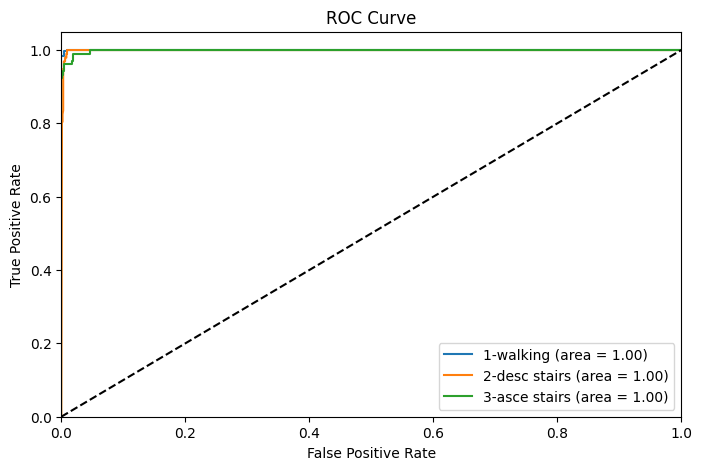

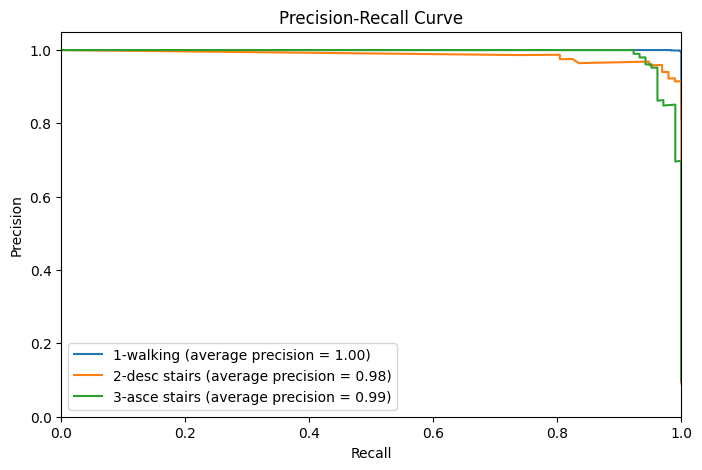

Final Accuracy: 0.9897196292877197
Final Precision: 0.9897998864792001
Final Recall: 0.9897196261682243
Final F1 Score: 0.9896822330195634


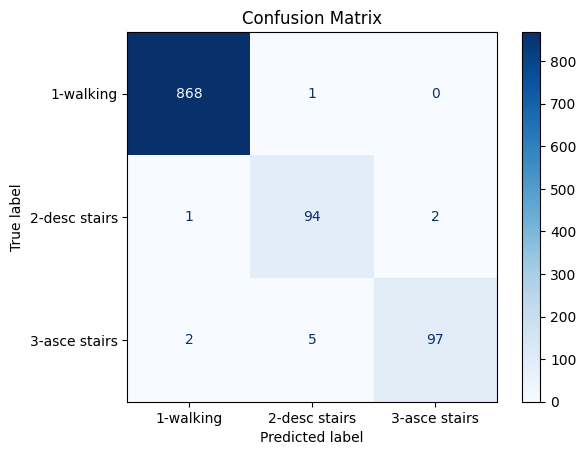

signal selected: ra_r
Label counts using Counter:
Label: 1, Count: 2894
Label: 2, Count: 323
Label: 3, Count: 348
Train class distribution: {0: 2025, 1: 226, 2: 244}
Test class distribution: {0: 869, 1: 97, 2: 104}
X_train shape: (2495, 512, 1)
X_test shape: (1070, 512, 1)
y_train shape: (2495,)
y_test shape: (1070,)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_128 (Conv1D)         (None, 510, 64)           256       
                                                                 
 batch_normalization_128 (Ba  (None, 510, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_128 (MaxPooli  (None, 255, 64)          0         
 ng1D)                                                           
                                                                

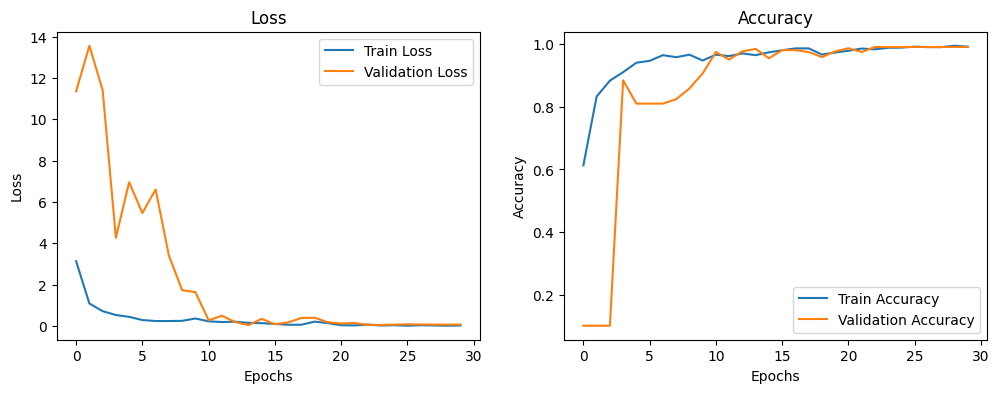

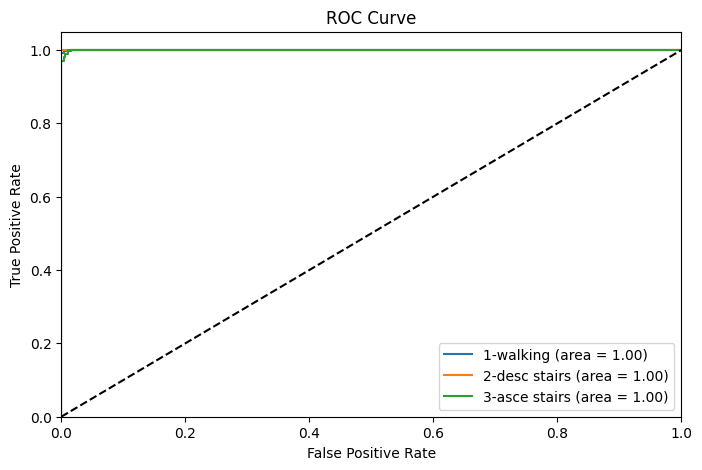

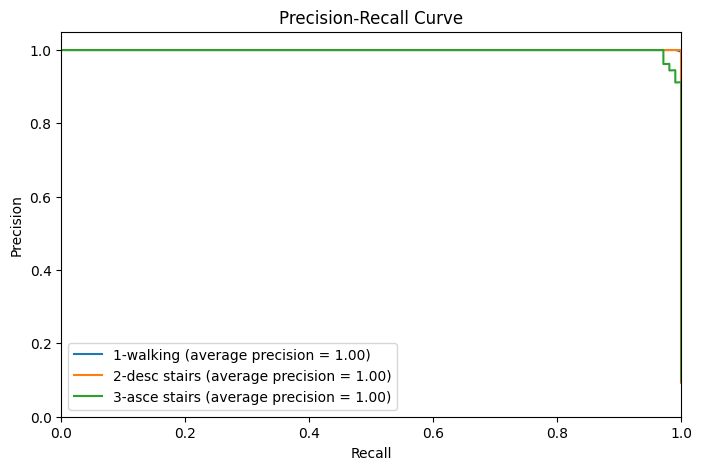

Final Accuracy: 0.9962616562843323
Final Precision: 0.9962788108466883
Final Recall: 0.9962616822429906
Final F1 Score: 0.9962293240525498


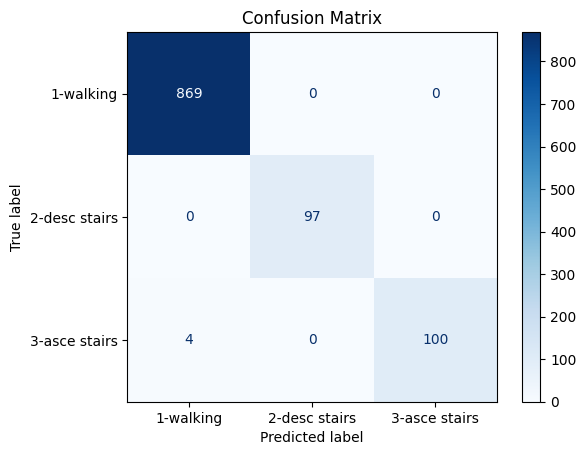

In [41]:

signals_list = ['lw_r', 'lh_r', 'la_r', 'ra_r']
for signall in signals_list:
    print('signal selected:',signall)
    results(df_normalized,512,512,signall,30,32)

# Part 3: 1024 samples 

signal selected: lh_r
Label counts using Counter:
Label: 1, Count: 5536
Label: 2, Count: 272
Label: 3, Count: 309
Train class distribution: {0: 3875, 1: 190, 2: 216}
Test class distribution: {0: 1661, 1: 82, 2: 93}
X_train shape: (4281, 1024, 1)
X_test shape: (1836, 1024, 1)
y_train shape: (4281,)
y_test shape: (1836,)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_132 (Conv1D)         (None, 1022, 64)          256       
                                                                 
 batch_normalization_132 (Ba  (None, 1022, 64)         256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_132 (MaxPooli  (None, 511, 64)          0         
 ng1D)                                                           
                                                              

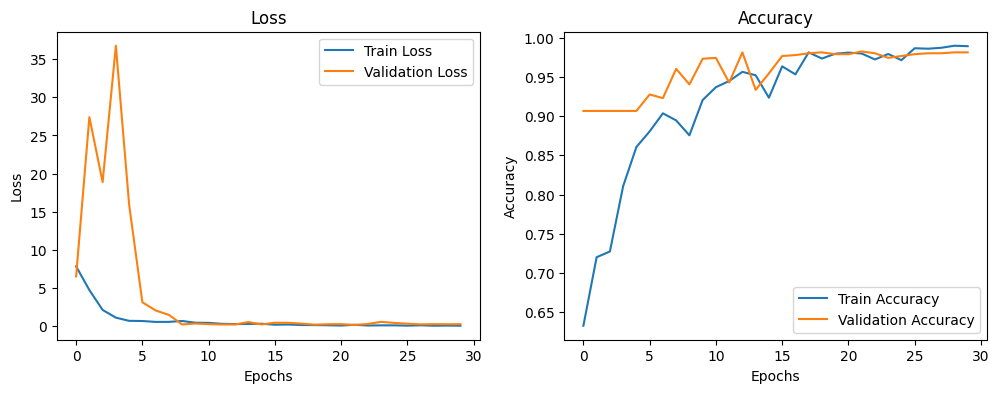

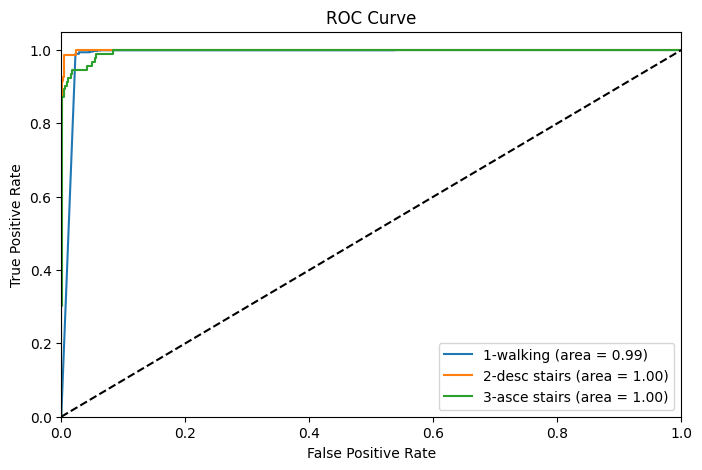

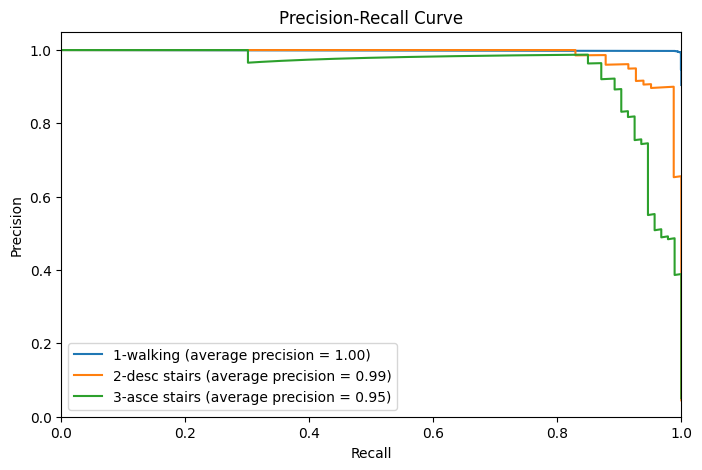

Final Accuracy: 0.9852941036224365
Final Precision: 0.985461234446174
Final Recall: 0.9852941176470589
Final F1 Score: 0.9846865496004363


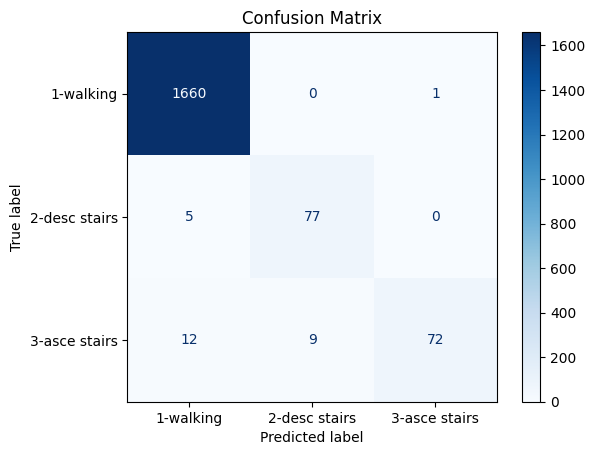

signal selected: lw_r
Label counts using Counter:
Label: 1, Count: 5536
Label: 2, Count: 272
Label: 3, Count: 309
Train class distribution: {0: 3875, 1: 190, 2: 216}
Test class distribution: {0: 1661, 1: 82, 2: 93}
X_train shape: (4281, 1024, 1)
X_test shape: (1836, 1024, 1)
y_train shape: (4281,)
y_test shape: (1836,)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_136 (Conv1D)         (None, 1022, 64)          256       
                                                                 
 batch_normalization_136 (Ba  (None, 1022, 64)         256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_136 (MaxPooli  (None, 511, 64)          0         
 ng1D)                                                           
                                                              

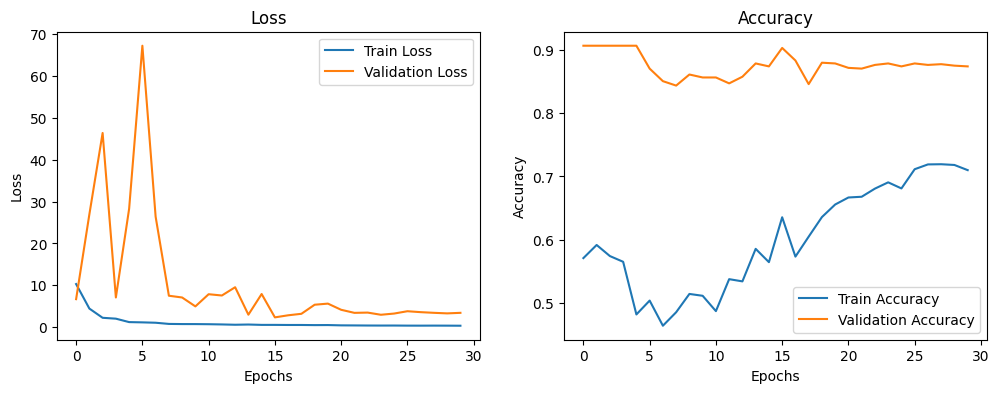

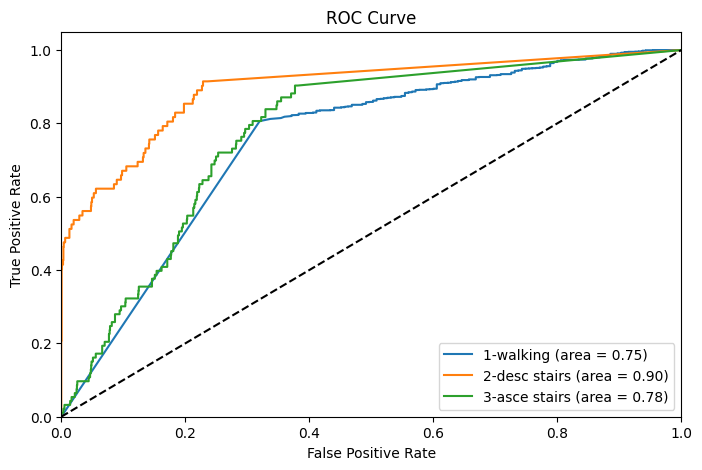

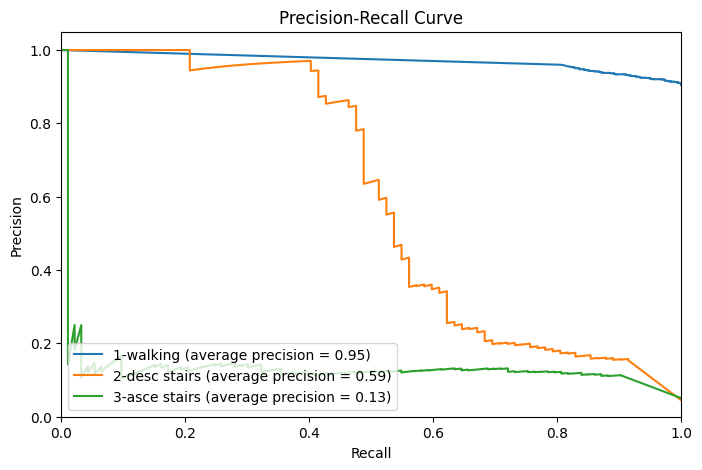

Final Accuracy: 0.8736383318901062
Final Precision: 0.8832485014321543
Final Recall: 0.8736383442265795
Final F1 Score: 0.8688779372437391


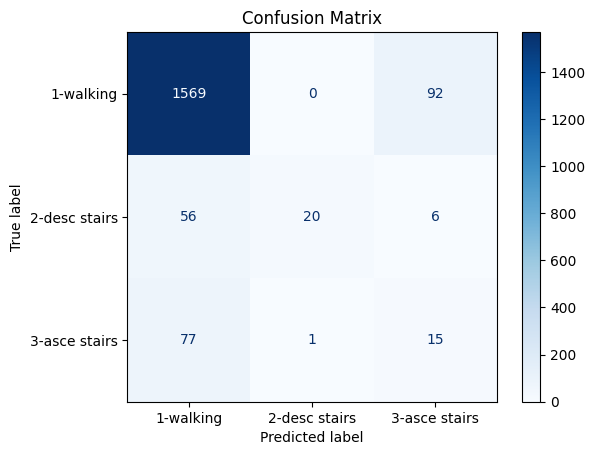

signal selected: la_r
Label counts using Counter:
Label: 1, Count: 5536
Label: 2, Count: 272
Label: 3, Count: 309
Train class distribution: {0: 3875, 1: 190, 2: 216}
Test class distribution: {0: 1661, 1: 82, 2: 93}
X_train shape: (4281, 1024, 1)
X_test shape: (1836, 1024, 1)
y_train shape: (4281,)
y_test shape: (1836,)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_140 (Conv1D)         (None, 1022, 64)          256       
                                                                 
 batch_normalization_140 (Ba  (None, 1022, 64)         256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_140 (MaxPooli  (None, 511, 64)          0         
 ng1D)                                                           
                                                              

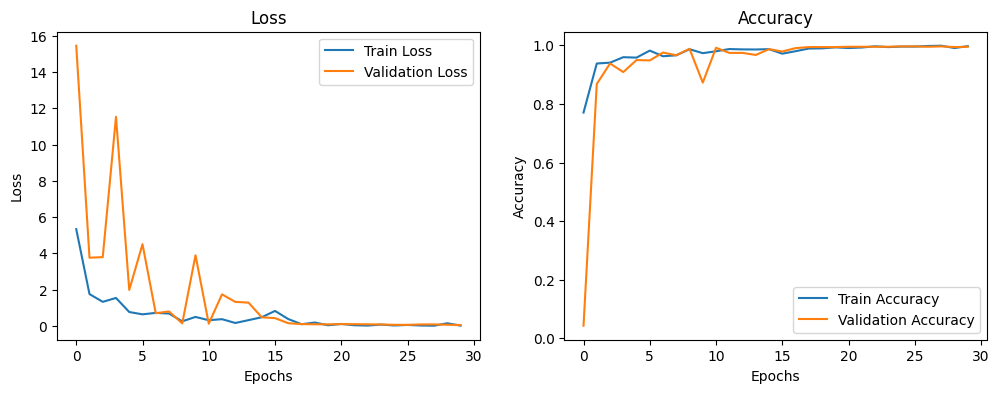

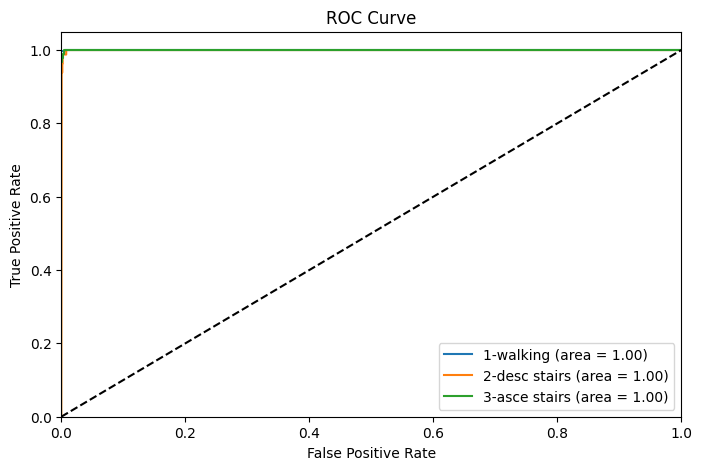

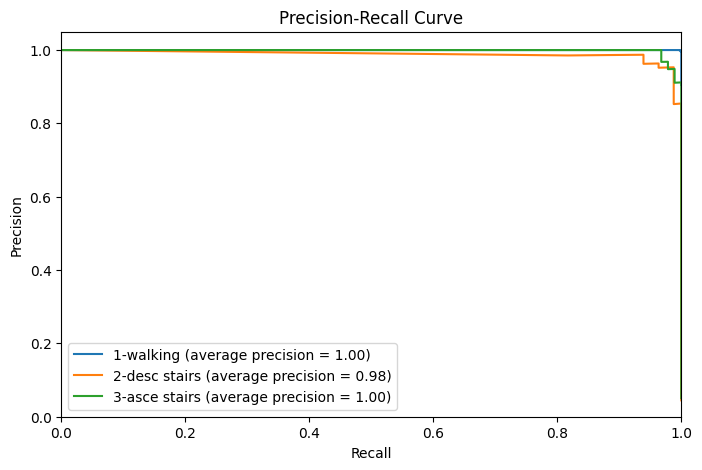

Final Accuracy: 0.9956427216529846
Final Precision: 0.9956939175107455
Final Recall: 0.9956427015250545
Final F1 Score: 0.9956617318948999


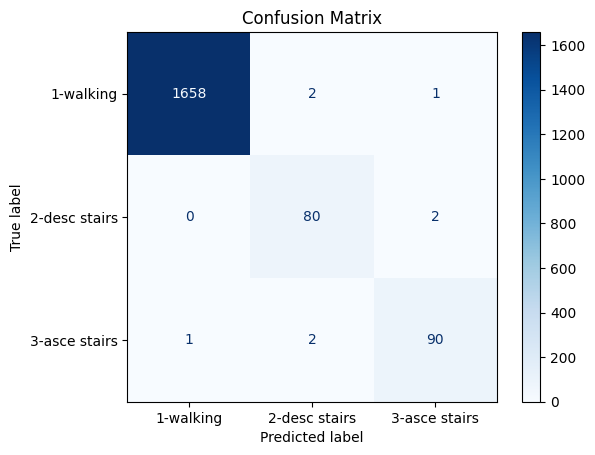

signal selected: ra_r
Label counts using Counter:
Label: 1, Count: 5536
Label: 2, Count: 272
Label: 3, Count: 309
Train class distribution: {0: 3875, 1: 190, 2: 216}
Test class distribution: {0: 1661, 1: 82, 2: 93}
X_train shape: (4281, 1024, 1)
X_test shape: (1836, 1024, 1)
y_train shape: (4281,)
y_test shape: (1836,)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_144 (Conv1D)         (None, 1022, 64)          256       
                                                                 
 batch_normalization_144 (Ba  (None, 1022, 64)         256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_144 (MaxPooli  (None, 511, 64)          0         
 ng1D)                                                           
                                                              

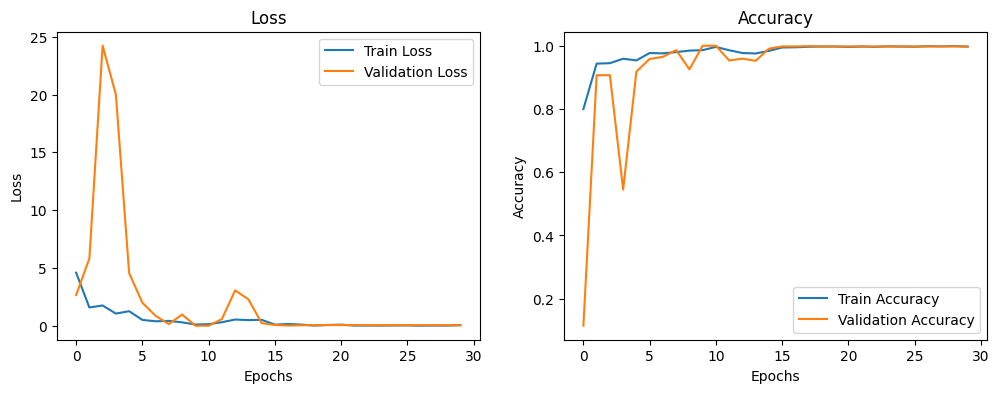

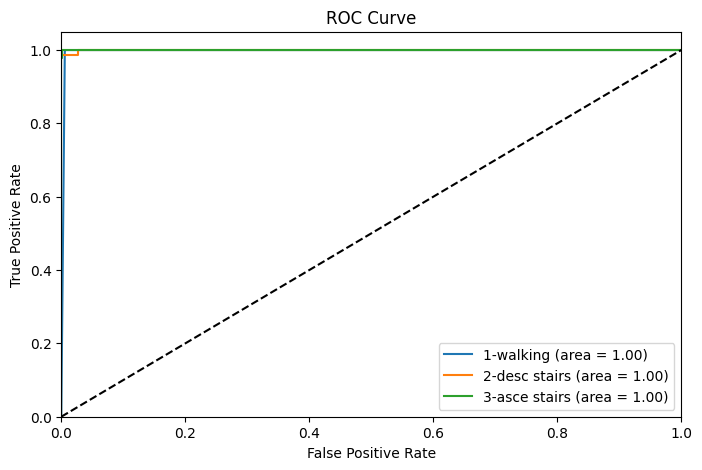

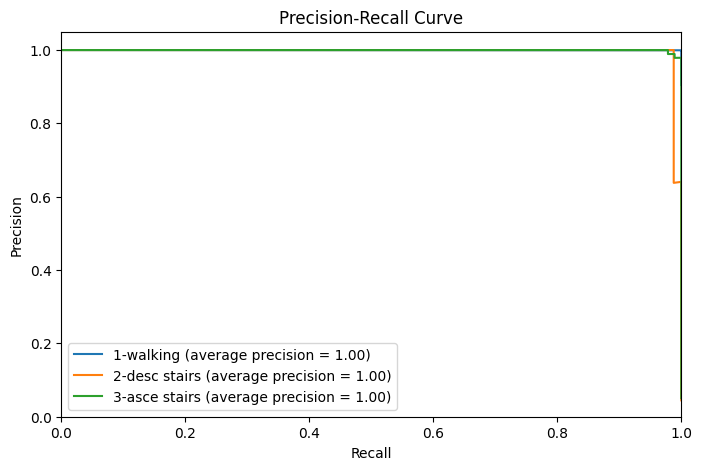

Final Accuracy: 0.9961873888969421
Final Precision: 0.9962071255981185
Final Recall: 0.9961873638344226
Final F1 Score: 0.9961317290186845


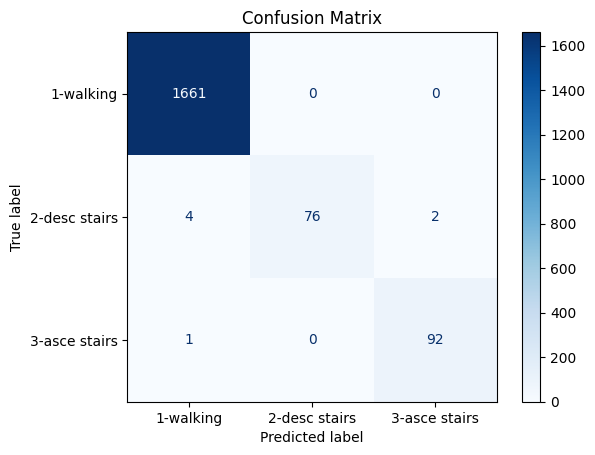

In [43]:
signals_list = [ 'lh_r','lw_r', 'la_r', 'ra_r']
for signall in signals_list:
    print('signal selected:',signall)
    results(df_normalized,1024,256,signall,epoch=30,batch_size=32)

# Part 4 CNN model for general data 256 Samples

In [21]:
signal_columns = ['lw_r', 'lh_r', 'la_r', 'ra_r']

def build_cnn_model2(input_size, num_features, num_classes=3):
    input_shape = (input_size, num_features)
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=512, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  
    ])
    return model

In [22]:
input_size = 256
num_features = len(signal_columns)
model = build_cnn_model2(input_size, num_features, 3)

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 254, 64)           832       
                                                                 
 batch_normalization_48 (Bat  (None, 254, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_48 (MaxPoolin  (None, 127, 64)          0         
 g1D)                                                            
                                                                 
 dropout_72 (Dropout)        (None, 127, 64)           0         
                                                                 
 conv1d_49 (Conv1D)          (None, 125, 128)          24704     
                                                                 
 batch_normalization_49 (Bat  (None, 125, 128)       

In [24]:
windows, labels = create_windows(df_normalized, 256, 256, signal_columns)
windows = windows.reshape((windows.shape[0], windows.shape[1], len(signal_columns)))
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
X_train, X_val, y_train, y_val = train_test_split(windows, labels, test_size=0.3, random_state=42,stratify=labels)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))


In [25]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val),callbacks=[early_stopping,reduce_lr])

Epoch 1/20
84/84 [==============================] - 3s 15ms/step - loss: 0.9099 - accuracy: 0.7583 - val_loss: 0.7433 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 2/20
84/84 [==============================] - 1s 11ms/step - loss: 0.3072 - accuracy: 0.8870 - val_loss: 1.9069 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 3/20
84/84 [==============================] - 1s 11ms/step - loss: 0.2017 - accuracy: 0.9291 - val_loss: 2.9171 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 4/20
84/84 [==============================] - 1s 11ms/step - loss: 0.1662 - accuracy: 0.9435 - val_loss: 3.5322 - val_accuracy: 0.7762 - lr: 0.0010
Epoch 5/20
84/84 [==============================] - 1s 11ms/step - loss: 0.1207 - accuracy: 0.9590 - val_loss: 2.1856 - val_accuracy: 0.8045 - lr: 0.0010
Epoch 6/20
82/84 [============================>.] - ETA: 0s - loss: 0.1031 - accuracy: 0.9649
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
84/84 [==============================] - 1s 11ms/step - los

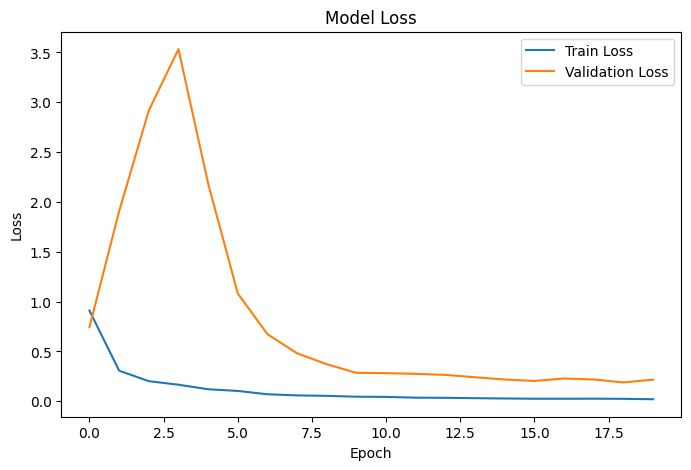

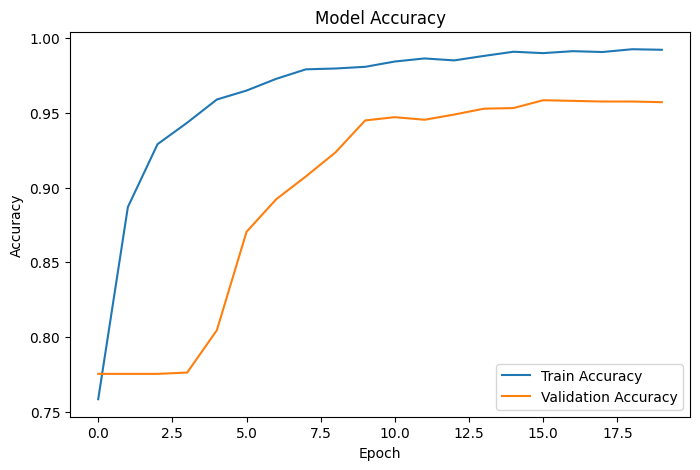

In [26]:
# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

72/72 [==============================] - 0s 5ms/step


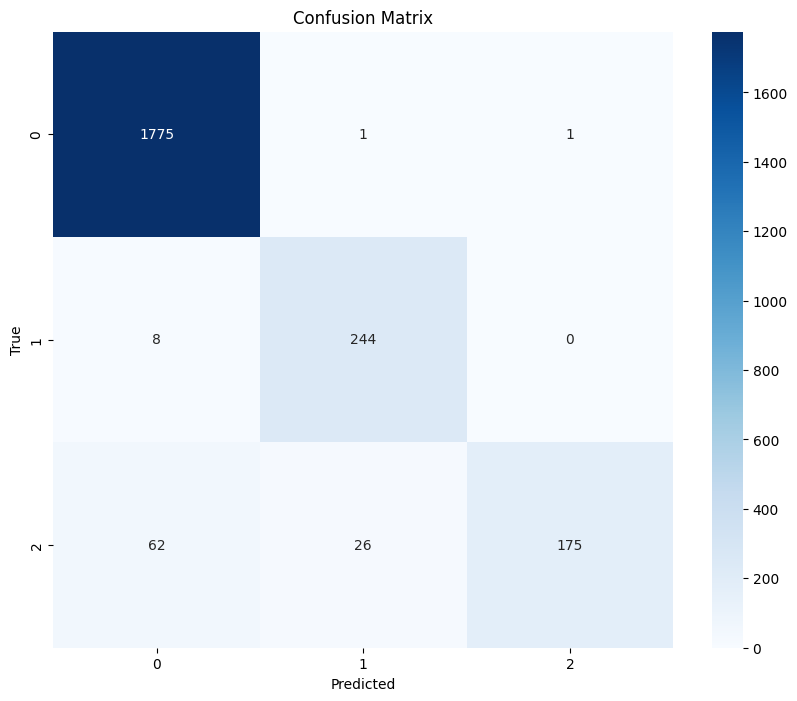

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1777
           1       0.90      0.97      0.93       252
           2       0.99      0.67      0.80       263

    accuracy                           0.96      2292
   macro avg       0.95      0.88      0.90      2292
weighted avg       0.96      0.96      0.95      2292



In [27]:
predictions = model.predict(X_val)

# Convert the predictions from probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report for additional metrics
print(classification_report(y_val, predicted_classes))

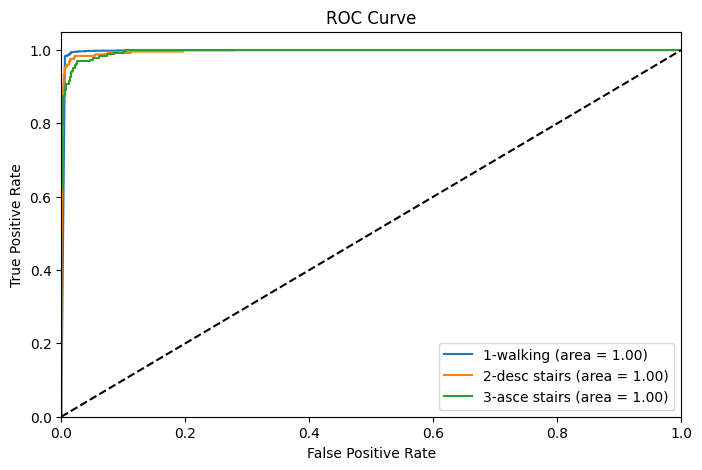

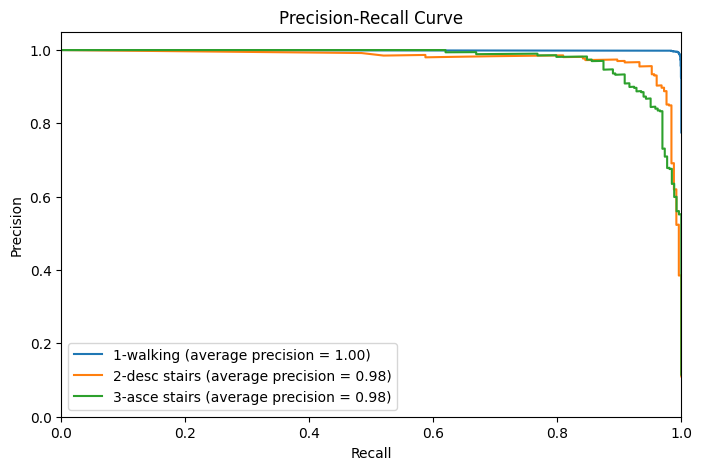

In [28]:
plot_roc_prc(y_true=y_val,y_pred_probs=predictions,class_names=class_names)